<a href="https://colab.research.google.com/github/marjanaziminezhad/structural_bioinformatics/blob/main/ex01/ex01_extract_and_analyse_pdb_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 01

## Aim of the exercise

The goal of this exercise is to extract and analyse pdb files from the PDB database.

We will learn how to:

- perform queries to the pdb database
- extract pdb IDs – each structure is defined by its ID code
- extract information about structures
- perform different analyses (e.g. find  structure with lowest resolution)

partially based on [Drazen Petrov](https://orcid.org/0000-0001-6221-7369)'s Exercises and on [TeachOpenCADD](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x) and

In [ ]:
# Check if running on Google Colab
try:
    from google.colab import drive
    is_google_colab = True
except ImportError:
    is_google_colab = False

# If on Google Colab, install the package
if is_google_colab:
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    !pip install numpy==1.23.5 scipy==1.11.3 pandas==1.5.3 matplotlib==3.7.1 biopandas==0.4.1 pypdb==2.3 tqdm==4.66.1 py3dmol==2.0.4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# import needed libraries
import math

import requests
import json
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import pypdb

mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = [5, 3]

## PDB Protein Data Bank

The [RCSB PDB](https://www.rcsb.org/) (Research Collaboratory for Structural Bioinformatics Protein Data Bank) is a comprehensive database for the 3D structural information of biological macromolecules. The aim of RCSB PDB is to provide open access to 3D structural data of biological macromolecules to advance research and understanding of molecular biology and biochemistry. The RCSB PDB also provides a variety of tools and resources. Users can perform simple and advanced searches based on annotations relating to sequence, structure and function. These molecules are visualized, downloaded, and analyzed by users who range from students to specialized scientists.



### Protein of interest

Today we will take a look at the human tyrosine-protein kinase. This protein is involved in cell differentiation, cell division, cell adhesion, stress response and apoptosis. It is also a target for cancer therapy.

The UNIPROT ID of this protein is P00519. You can find more information about this protein at [https://www.uniprot.org/uniprot/P00519](https://www.uniprot.org/uniprot/P00519)

To perform a search in the PDB database, copy the uniprot id (P00519) to the search box at [https://www.rcsb.org/](https://www.rcsb.org/)
Be free to explore the website and the information available for this protein.

### Programmatic access to PDB

While performing search over the website is straightforward, making repeated searches to systematically analyze structures of interest is only possible using a programmatic access.

Therefore, we will use the [PDB Search API](https://www.rcsb.org/docs/programmatic-access/web-services) to perform queries to the PDB database.

How does it work? The API lets you search the PDB database with a JSON query in a URL and retrieve results in JSON format for further extraction.

The API is well document in [https://search.rcsb.org/index.html#search-api](https://search.rcsb.org/index.html#search-api). You can find there also examples of queries [https://search.rcsb.org/index.html#examples](https://search.rcsb.org/index.html#examples).

We will use [pypdb](https://github.com/williamgilpin/pypdb) to easily access and download PDB data based on metadata like protein and ligand names.


In [ ]:
# prepare search parameters using the uniprot ID of ABL1 (P00519)
search_dict = {
  "query": {
    "type": "terminal",
    "label": "full_text",
    "service": "full_text",
    "parameters": {
      "value": "P01053"
    }
  },
  "return_type": "entry",
  "request_options": {
    "paginate": {
      "start": 0,
      "rows": 10000
    },
    "results_content_type": [
      "experimental"
    ],
    "sort": [
      {
        "sort_by": "score",
        "direction": "desc"
      }
    ],
    "scoring_strategy": "combined"
  }
}

In [ ]:
# performing the search
response = requests.get('https://search.rcsb.org/rcsbsearch/v2/query?json=' + json.dumps(search_dict))
data = response.json()
# printing the keys of the retreived dictionary
data.keys()

dict_keys(['query_id', 'result_type', 'total_count', 'result_set'])

In [ ]:
# showing the total number of hits (how does this compare to the search performed on the website directly?)
data['total_count'], len(data['result_set'])

(20, 20)

In [ ]:
data['result_set'][0]

{'identifier': '1CIR', 'score': 1.0}

In [ ]:
def exctract_pdb_ids(search_result):
    pdb_IDs = []
    for entry in search_result['result_set']:
        pdb_IDs.append(entry['identifier'])
    return pdb_IDs

found_pdb_ids = exctract_pdb_ids(data)

In [ ]:
# here we look at how many hits we got
len(found_pdb_ids)

20

In [ ]:
# here we look at the first 10 pdb codes
found_pdb_ids[:10]

['1CIR',
 '1CIQ',
 '1CQ4',
 '1YPA',
 '1YPB',
 '1YPC',
 '2CI2',
 '6QIY',
 '6QIZ',
 '7A3M']

### Extracting information of one protein

In [ ]:
# let's take a look at some information about one of the structures from the list (PDB ID 7A3M)
pdb_7a3m_info = pypdb.get_info("7A3M")
for key, value in pdb_7a3m_info.items():
    #print(key, value) # this line would print all the data available (long output)!
    print(key, end=", ") # here we just print the keys

audit_author, cell, citation, diffrn, diffrn_detector, diffrn_radiation, diffrn_source, entry, exptl, exptl_crystal, exptl_crystal_grow, pdbx_audit_revision_category, pdbx_audit_revision_details, pdbx_audit_revision_group, pdbx_audit_revision_history, pdbx_audit_revision_item, pdbx_audit_support, pdbx_database_related, pdbx_database_status, rcsb_accession_info, rcsb_entry_container_identifiers, rcsb_entry_info, rcsb_primary_citation, refine, refine_hist, refine_ls_restr, reflns, reflns_shell, software, struct, struct_keywords, symmetry, rcsb_id, 

Now, our problems is the fact that we have to much information. We are interested in parameters as resolution, method, date, number of atoms, etc.

Let's try to extract this information from the dictionary.

now try to do the same search direct on the PDB website https://www.rcsb.org/

In [ ]:
# let's extract some of the (interesting) information
# of course, what is interesting depends on the project you are involved in
# this is one example of such a function
def extract_interesting_info(pdb_info):
    info = {
        "pdb_id" : pdb_info['rcsb_id'],
        "desc" : pdb_info['struct'].get('pdbx_descriptor'),
        "title" : pdb_info['struct']['title'],
        "method" : pdb_info['exptl'][0]['method'],
        "date" : pdb_info['rcsb_accession_info']['deposit_date'],
        "num_atoms" : pdb_info['rcsb_entry_info']['deposited_atom_count'],
        "resolution" : None,
        "rwork" : None,
        "rfree" : None
    }

    # only for X-ray
    try:
        xray_info = {
        "resolution" : pdb_info['refine'][0]['ls_dres_high'],
        "rwork" : pdb_info['refine'][0]['ls_rfactor_rwork'],
        "rfree" : pdb_info['refine'][0]['ls_rfactor_rfree'],
        }
        info.update(xray_info)
    except:
        pass


    return info #pdb_id, desc, title, method, date, num_atoms, resolution, rwork, rfree

In [ ]:
extract_interesting_info(pdb_7a3m_info)

{'pdb_id': '7A3M',
 'desc': None,
 'title': 'Synergistic stabilization of a double mutant in CI2 from an in-cell library screen',
 'method': 'X-RAY DIFFRACTION',
 'date': '2020-08-18T00:00:00+0000',
 'num_atoms': 625,
 'resolution': 1.01,
 'rwork': 0.1489,
 'rfree': 0.181}

### Extracting information of the found proteins

We will use the function defined `extract_interesting_info` to extract the information of each protein.

In [ ]:
# let’s collect data for all retrieved pdb codes
pdb_data = []
for pdb_id in tqdm(found_pdb_ids):
    pdb_data.append(extract_interesting_info(pypdb.get_info(pdb_id)))

100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


In [ ]:
# now we store this data in a pandas dataframe
pdbs = pd.DataFrame(pdb_data)
pdbs[:10]

,pdb_id,desc,title,method,date,num_atoms,resolution,rwork,rfree
0,1CIR,None,COMPLEX OF TWO FRAGMENTS OF CI2 [(1-40)(DOT)(4...,SOLUTION NMR,1995-10-02T00:00:00+0000,505,NaN,NaN,NaN
1,1CIQ,CHYMOTRYPSIN INHIBITOR 2,"COMPLEX OF TWO FRAGMENTS OF CI2, RESIDUES 1-40...",X-RAY DIFFRACTION,1995-10-02T00:00:00+0000,535,NaN,NaN,NaN
2,1CQ4,None,CI2 MUTANT WITH TETRAGLUTAMINE (MGQQQQGM) REPL...,X-RAY DIFFRACTION,1998-11-17T00:00:00+0000,541,1.80,0.2400,0.300
3,1YPA,CHYMOTRYPSIN INHIBITOR 2 (CI2) MUTANT WITH SER...,DIRECT OBSERVATION OF BETTER HYDRATION AT THE ...,X-RAY DIFFRACTION,1993-01-10T00:00:00+0000,555,NaN,NaN,NaN
4,1YPB,CHYMOTRYPSIN INHIBITOR 2 (CI2) MUTANT WITH SER...,DIRECT OBSERVATION OF BETTER HYDRATION AT THE ...,X-RAY DIFFRACTION,1993-01-10T00:00:00+0000,556,NaN,NaN,NaN
5,1YPC,CHYMOTRYPSIN INHIBITOR 2 (CI2) MUTANT WITH GLU...,DIRECT OBSERVATION OF BETTER HYDRATION AT THE ...,X-RAY DIFFRACTION,1993-01-10T00:00:00+0000,575,NaN,NaN,NaN
6,2CI2,CHYMOTRYPSIN INHIBITOR 2 (CI-2),CRYSTAL AND MOLECULAR STRUCTURE OF THE SERINE ...,X-RAY DIFFRACTION,1988-09-05T00:00:00+0000,585,NaN,NaN,NaN
7,6QIY,Subtilisin-chymotrypsin inhibitor-2A,"CI-2, conformation 1",X-RAY DIFFRACTION,2019-01-21T00:00:00+0000,592,1.50,0.2110,0.257
8,6QIZ,Subtilisin-chymotrypsin inhibitor-2A,"CI-2, conformation 2",X-RAY DIFFRACTION,2019-01-21T00:00:00+0000,626,1.65,0.1840,0.220
9,7A3M,None,Synergistic stabilization of a double mutant i...,X-RAY DIFFRACTION,2020-08-18T00:00:00+0000,625,1.01,0.1489,0.181


#### Let's make some plots

looking at the release years and resolution of the structures

In [ ]:
# a little bit of preprocessing
# let's convert the date column to datetime format
pdbs['date'] = pd.to_datetime(pdbs['date'])
pdbs['year'] = pdbs['date'].dt.year

<Axes: xlabel='date'>

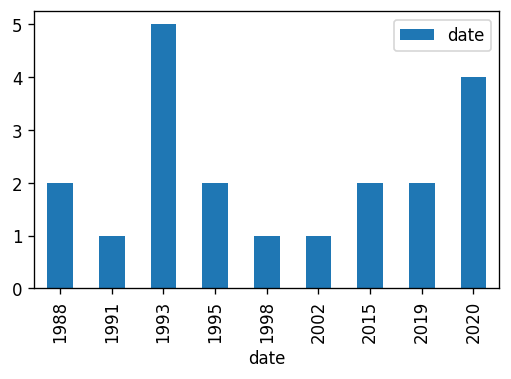

In [ ]:
df = pdbs
df[['date']].groupby(df["date"].dt.year).count().plot(kind="bar")

In [ ]:
structures_per_year = pdbs['year'].value_counts().reset_index().sort_values('year')
structures_per_year

,index,year
6,1998,1
7,1991,1
8,2002,1
2,1995,2
3,1988,2
4,2019,2
5,2015,2
1,2020,4
0,1993,5


In [ ]:
# let's plot the number of structures per year
#structures_per_year = pdbs['year'].value_counts().reset_index().sort_values('year') # <- this works for pandas>=2.0
structures_per_year = pdbs['year'].value_counts().reset_index()
structures_per_year.columns = ['year', 'count']
structures_per_year.sort_values('year', inplace=True)
structures_per_year

,year,count
3,1988,2
7,1991,1
0,1993,5
2,1995,2
6,1998,1
8,2002,1
5,2015,2
4,2019,2
1,2020,4


<Axes: xlabel='year'>

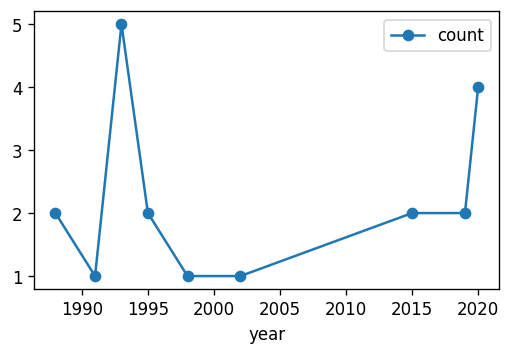

In [ ]:
# let's plot the number of structures per year
structures_per_year.plot(x='year', y='count', style='o-')

In [ ]:
# let's plot how the resolution changed over the years
pdbs = pdbs.sort_values(["year"],
                        ascending=True,
                        na_position='last')
pdbs[['date', 'year', 'resolution']].head(10)

,date,year,resolution
19,1988-09-05 00:00:00+00:00,1988,NaN
6,1988-09-05 00:00:00+00:00,1988,NaN
14,1991-09-10 00:00:00+00:00,1991,NaN
13,1993-05-14 00:00:00+00:00,1993,NaN
3,1993-01-10 00:00:00+00:00,1993,NaN
4,1993-01-10 00:00:00+00:00,1993,NaN
5,1993-01-10 00:00:00+00:00,1993,NaN
12,1993-04-23 00:00:00+00:00,1993,NaN
0,1995-10-02 00:00:00+00:00,1995,NaN
1,1995-10-02 00:00:00+00:00,1995,NaN


<Axes: xlabel='year'>

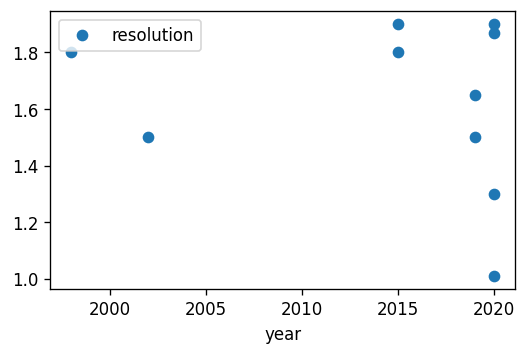

In [ ]:
pdbs.plot(x='year', y='resolution', style='o')

In [ ]:
# let's observe the type of methods used to obtain the structures
pdbs['method'].unique()

array(['X-RAY DIFFRACTION', 'SOLUTION NMR'], dtype=object)

In [ ]:
pdbs[pdbs.method=='X-RAY DIFFRACTION'][:10]

,pdb_id,desc,title,method,date,num_atoms,resolution,rwork,rfree,year
19,2SNI,SUBTILISIN NOVO (E.C.3.4.21.14) COMPLEX WITH C...,STRUCTURAL COMPARISON OF TWO SERINE PROTEINASE...,X-RAY DIFFRACTION,1988-09-05 00:00:00+00:00,2621,NaN,NaN,NaN,1988
6,2CI2,CHYMOTRYPSIN INHIBITOR 2 (CI-2),CRYSTAL AND MOLECULAR STRUCTURE OF THE SERINE ...,X-RAY DIFFRACTION,1988-09-05 00:00:00+00:00,585,NaN,NaN,NaN,1988
13,1COA,CHYMOTRYPSIN INHIBITOR 2 (CI2) MUTANT WITH ILE...,THE EFFECT OF CAVITY CREATING MUTATIONS IN THE...,X-RAY DIFFRACTION,1993-05-14 00:00:00+00:00,544,NaN,NaN,NaN,1993
3,1YPA,CHYMOTRYPSIN INHIBITOR 2 (CI2) MUTANT WITH SER...,DIRECT OBSERVATION OF BETTER HYDRATION AT THE ...,X-RAY DIFFRACTION,1993-01-10 00:00:00+00:00,555,NaN,NaN,NaN,1993
4,1YPB,CHYMOTRYPSIN INHIBITOR 2 (CI2) MUTANT WITH SER...,DIRECT OBSERVATION OF BETTER HYDRATION AT THE ...,X-RAY DIFFRACTION,1993-01-10 00:00:00+00:00,556,NaN,NaN,NaN,1993
5,1YPC,CHYMOTRYPSIN INHIBITOR 2 (CI2) MUTANT WITH GLU...,DIRECT OBSERVATION OF BETTER HYDRATION AT THE ...,X-RAY DIFFRACTION,1993-01-10 00:00:00+00:00,575,NaN,NaN,NaN,1993
1,1CIQ,CHYMOTRYPSIN INHIBITOR 2,"COMPLEX OF TWO FRAGMENTS OF CI2, RESIDUES 1-40...",X-RAY DIFFRACTION,1995-10-02 00:00:00+00:00,535,NaN,NaN,NaN,1995
2,1CQ4,None,CI2 MUTANT WITH TETRAGLUTAMINE (MGQQQQGM) REPL...,X-RAY DIFFRACTION,1998-11-17 00:00:00+00:00,541,1.8,0.24000,0.30000,1998
18,1LW6,None,Crystal Structure of the Complex of Subtilisin...,X-RAY DIFFRACTION,2002-05-30 00:00:00+00:00,3049,1.5,0.16900,0.18800,2002
16,5FFN,None,Complex of subtilase SubTY from Bacillus sp. T...,X-RAY DIFFRACTION,2015-12-18 00:00:00+00:00,3219,1.8,0.15098,0.18839,2015


In [ ]:
pdbs[pdbs.method=='X-RAY DIFFRACTION'].head().resolution

19   NaN
6    NaN
13   NaN
3    NaN
4    NaN
Name: resolution, dtype: float64

array([[<Axes: title={'center': 'resolution'}>]], dtype=object)

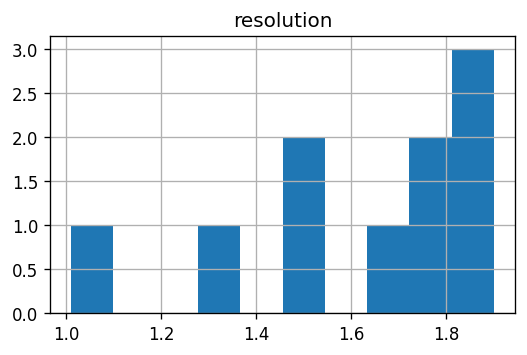

In [ ]:
pdbs.hist(column = 'resolution')

<img src="https://biopandas.github.io/biopandas/img/logos/logo_size_1.png" width="200" align="left"/>

## biopandas

[BioPandas](https://biopandas.github.io/biopandas/) simplifies the handling of protein structure files, such as PDB files, for computational biologists. It utilizes pandas DataFrames, widely used in data science, to work with biological macromolecule structures from PDB and MOL2 files in structural biology.

We will use it to extract the structure with the lowest resolution

In [ ]:
from biopandas.pdb import PandasPdb

In [ ]:
pdbs['resolution'].min()


1.01

In [ ]:
pdbs['resolution'].max()

1.9

In [ ]:
pdbs['resolution'].idxmin()

9

In [ ]:
ID_min = pdbs['resolution'].idxmin()
pdbs.iloc[ID_min]


pdb_id                                                     1CIQ
desc                                   CHYMOTRYPSIN INHIBITOR 2
title         COMPLEX OF TWO FRAGMENTS OF CI2, RESIDUES 1-40...
method                                        X-RAY DIFFRACTION
date                                  1995-10-02 00:00:00+00:00
num_atoms                                                   535
resolution                                                  NaN
rwork                                                       NaN
rfree                                                       NaN
year                                                       1995
Name: 1, dtype: object

In [ ]:
pdbs['pdb_id'].iloc[ID_min]

'1CIQ'

In [ ]:
pdb_ID = pdbs['pdb_id'].iloc[ID_min]
ppdb = PandasPdb().fetch_pdb(pdb_ID)
ppdb

In [ ]:
ppdb.df['ATOM'].head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,LYS,,A,2,,...,8.807,-32.611,7.110,1.0,34.28,,,N,NaN,424
1,ATOM,2,,CA,,LYS,,A,2,,...,7.715,-32.024,7.949,1.0,34.29,,,C,NaN,425
2,ATOM,3,,C,,LYS,,A,2,,...,7.868,-30.519,7.716,1.0,32.72,,,C,NaN,426
3,ATOM,4,,O,,LYS,,A,2,,...,8.712,-29.968,8.423,1.0,33.33,,,O,NaN,427
4,ATOM,5,,CB,,LYS,,A,2,,...,7.728,-32.332,9.429,1.0,36.36,,,C,NaN,428


<Axes: ylabel='Frequency'>

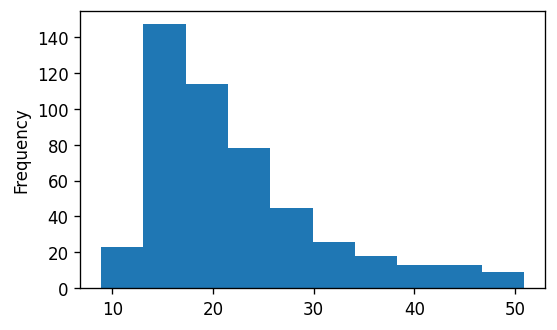

In [ ]:
ppdb.df['ATOM']['b_factor'].plot(kind='hist')

<Axes: >

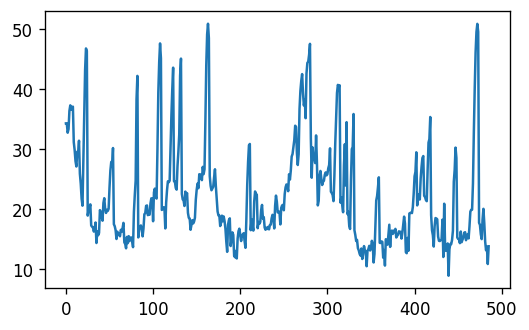

In [ ]:
ppdb.df['ATOM']['b_factor'].plot(kind='line')

In [ ]:
ppdb.df['ATOM'].x_coord[0]

8.807

In [ ]:
def get_coord(pdb, at):
    r = []
    for coord in ('x_coord', 'y_coord', 'z_coord'):
        r.append(ppdb.df['ATOM'][coord][at])
    return np.array(r)

def calc_dist(pdb,at1,at2):
    r1, r2 = get_coord(pdb, at1), get_coord(pdb, at2)
    r = r1-r2
    d = math.sqrt(sum(r**2))
    d_alternative = np.linalg.norm(r)
    return d, d_alternative

calc_dist(ppdb, 0, 1)


(1.496981629813805, 1.496981629813805)

In [ ]:
# help(ppdb)
# execute to see what other function are available

In [ ]:
get_coord(ppdb, 0)
#ppdb.distance()

array([  8.807, -32.611,   7.11 ])

In [ ]:
ppdb.distance(get_coord(ppdb, 0)).head()

0    0.000000
1    1.496982
2    2.371797
3    2.952701
4    2.572906
dtype: float64

In [ ]:


# Count the number of X-ray structures
xray_structures = len(pdbs[pdbs['method'] == 'X-RAY DIFFRACTION'])

# Count the number of NMR structures
nmr_structures = len(pdbs[pdbs['method'] == 'SOLUTION NMR'])


print("X-ray structures:", xray_structures)
print("NMR structures:", nmr_structures)


X-ray structures: 17
NMR structures: 3


In [ ]:
# Sort the data
sorted_pdbs = pdbs.sort_values(by='resolution')

print("Sorted structures by resolution:")
print(sorted_pdbs)


Sorted structures by resolution:
   pdb_id                                               desc  \
9    7A3M                                               None   
15   7AON                                               None   
18   1LW6                                               None   
7    6QIY               Subtilisin-chymotrypsin inhibitor-2A   
8    6QIZ               Subtilisin-chymotrypsin inhibitor-2A   
2    1CQ4                                               None   
16   5FFN                                               None   
11   7AOK                                               None   
17   5FBZ                                               None   
10   7A1H                                               None   
19   2SNI  SUBTILISIN NOVO (E.C.3.4.21.14) COMPLEX WITH C...   
6    2CI2                    CHYMOTRYPSIN INHIBITOR 2 (CI-2)   
14   3CI2  CHYMOTRYPSIN INHIBITOR 2 (SERINE PROTEINASE IN...   
13   1COA  CHYMOTRYPSIN INHIBITOR 2 (CI2) MUTANT WITH ILE...   
3    1Y

In [ ]:
# min and max Resolution again
min_resolution = pdbs['resolution'].min()
max_resolution = pdbs['resolution'].max()

print("Minimum resolution:", min_resolution)
print("Maximum resolution:", max_resolution)


Minimum resolution: 1.01
Maximum resolution: 1.9


## py3Dmol

py3Dmol is a wrapper around the 3Dmol.js JavaScript library.

In [ ]:
import py3Dmol
view = py3Dmol.view(query='pdb:7A3M')
view.setStyle({'cartoon':{'color':'spectrum'}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
import py3Dmol
from biopandas.pdb import PandasPdb

# Assuming pdbs is your DataFrame
pdb_ID = pdbs['pdb_id'].iloc[ID_min]

# Fetch the PDB information using PandasPdb
ppdb = PandasPdb().fetch_pdb(pdb_ID)

# Visualize the structure with B-factors using py3Dmol
viewer = py3Dmol.view(query=f'pdb:{pdb_ID}')

# Extract B-factors from the 'ATOM' DataFrame
b_factors = ppdb.df['ATOM']['b_factor'].tolist()

# Set style with B-factors for each atom
viewer.setStyle({'cartoon': {'color': 'spectrum', 'width': 0.6}, 'atoms': {'b': b_factors}})

# Show the visualization
viewer.show()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:

pdb_ID = pdbs['pdb_id'].iloc[ID_min]

# Fetch the PDB information using PandasPdb
ppdb = PandasPdb().fetch_pdb(pdb_ID)

# Visualize all structures (models) in the NMR ensemble using py3Dmol
viewer = py3Dmol.view(query=f'pdb:{pdb_ID}')

# Check if 'model' is a column in the 'ATOM' DataFrame
if 'model' in ppdb.df['ATOM']:
    # Iterate over each model and set style for each
    for model in ppdb.df['ATOM']['model'].unique():
        # Extract B-factors from the 'ATOM' DataFrame for the current model
        b_factors = ppdb.df['ATOM'][ppdb.df['ATOM']['model'] == model]['b_factor'].tolist()

        # Set style with B-factors for each atom in the current model
        viewer.setStyle({'model': model, 'cartoon': {'color': 'spectrum', 'width': 0.6}, 'atoms': {'b': b_factors}})
else:
    # If 'model' is not present, visualize all structures without distinguishing models
    b_factors = ppdb.df['ATOM']['b_factor'].tolist()
    viewer.setStyle({'cartoon': {'color': 'spectrum', 'width': 0.6}, 'atoms': {'b': b_factors}})

# Show the visualization
viewer.show()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Exercises

* Perform a PDB query on a protein of choice (e.g. from a uniprot ID or by textual input query) and retrieve the data from the PDB database - note to use a query that will lead to some tens or hundreds of structures
* How many structures have you retrieved and how many of them are X-ray and how many NMR?
* Sort the structures by the resolution
* What is the min and max resolution
* Visualize the structure b-factors (X-ray) or visualize all the structures per PDB (NMR). **Use py3Dmol for this task.**

## For the project
* chose one of the X-ray and one of the NMR structures and use pymol to visualize them (save visualizations as png files) - this task (pymol) only works on a local machine:<br>
   - download the PDB file from the PDB database
   - visualize secondary structure elements and describe the structure in terms of secondary structure, motifs, domain, ...
   - zoom to the ligand or heteroatoms (if present) and analyze the aminoacids involved in the interaction
   - for the X-ray structure, visualize b-factors by either changing the size of the atoms (spheres, see https://sourceforge.net/p/pymol/mailman/message/29616429/) or by color and cartoon thickness (see https://www.michaelchimenti.com/2014/09/five-cool-features-in-pymol-that-you-may-have-missed/)
   - for the NMR structure, visualize the bundle. An NMR bundle is a set of structures that satisfy experimental data. This set of structures is reported within one PDB file.


In [ ]:


# Select rows with X-ray structures
xray_data = pdbs[pdbs['method'] == 'X-RAY DIFFRACTION']

# Select rows with NMR structures
nmr_data = pdbs[pdbs['method'] == 'SOLUTION NMR']

# Display the content of X-ray structures
print("X-ray structures:")
print(xray_data)

# Display the content of NMR structures
print("\nNMR structures:")
print(nmr_data)


**describe the structure in terms of secondary structure, motifs, domain**
#**3CI2** /  **7A3M**

The three-dimensional structure of barley serine proteinase inhibitor, CI-2, revealed through nuclear magnetic resonance spectroscopy, exhibits a well-defined architecture characterized by distinct secondary structures and functional motifs. The protein's framework includes a prominent four-stranded beta-sheet structure, comprising parallel and antiparallel strands that form a central core. Three pairs of antiparallel beta-strands are flanked by a 12-residue alpha-helix on one side and a loop housing the serine proteinase binding site on the other
 The overall fold encompasses a well-defined inhibitory site with a loop region.

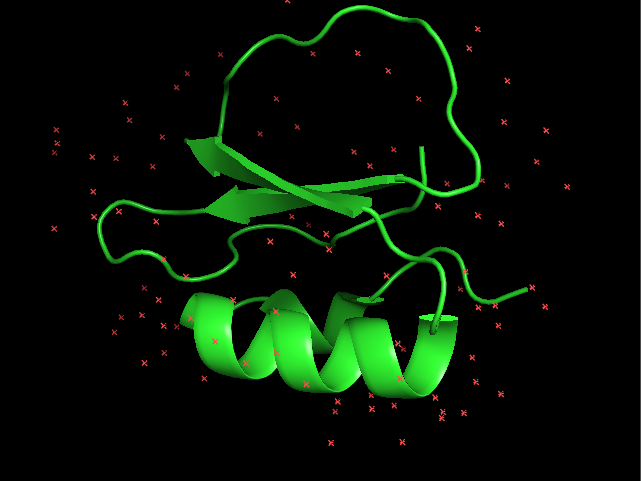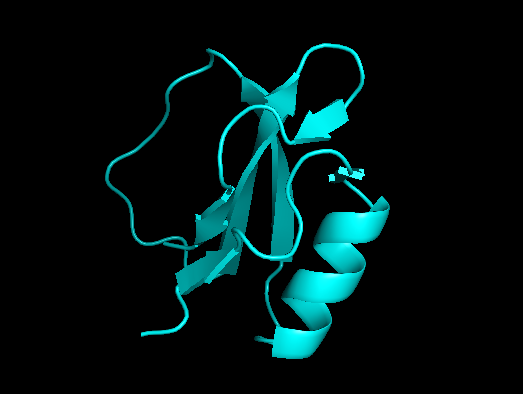

# Space for the Exercises
please provide your solutions below this cell.

Also you can provide me the information for the project. I can help you in the progress.

# **FOR ANSWERS PLEASE FOLLOW THE CODE FROM THE BEGINNING OF THE SCRIPT**
THANKS